In [45]:
# libraries 
from mesa import Agent, Model
from mesa.discrete_space import CellAgent, FixedAgent
from mesa.datacollection import DataCollector
from mesa.space import MultiGrid

import matplotlib.pyplot as plt
import math
import random

# custom scheduler 
class SimpleScheduler:
    def __init__(self):
        self.agents = []

    def add(self, agent):
        self.agents.append(agent)

    def remove(self, agent):
        if agent in self.agents:
            self.agents.remove(agent)

    def step(self):
        # Loop through a copy to allow safe removal
        for agent in self.agents[:]:
            agent.step()


# merozoites 
class Merozoite(Agent):
    def __init__(self, unique_id, model, pos):
        self.unique_id = unique_id
        self.model = model
        self.pos = pos

    def step(self):
        # Move randomly to a neighboring cell (Moore neighborhood)
        neighbors = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        new_pos = random.choice(neighbors)
        self.model.grid.move_agent(self, new_pos)

        # Try to infect any RBC in the new position
        cell_agents = self.model.grid.get_cell_list_contents([new_pos])
        for agent in cell_agents:
            if isinstance(agent, BloodCell):
                agent.infect()

# defining agents and behavior 
# blood cell 
class BloodCell(Agent):
    def __init__(self,  unique_id, model, pos, genotype="normal", infection_risk=0.5):
        self.model = model
        self.unique_id = unique_id
        self.pos = pos
        self.genotype = genotype
        self.infection_risk = infection_risk
        self.hp = 24
        self.infected = False

    def step(self):
        if self.infected:
            self.hp -= 1
        if self.infected and self.hp <= 0:
            self.resolve()

    def infect(self):
        #Called by a merozoite attempting to infect this RBC
        if not self.infected:
            if random.random() < self.infection_risk:
                self.infected = True
                self.hp = 23  # triggers bursting/removal in a few steps

    def resolve(self):
        #Handle bursting or dying based on genotype
        if self.genotype == "normal":
            self.burst()
        elif self.genotype == "heterozygous":
            if random.random() < 0.5:
                self.burst()  # 50% chance to burst
            # otherwise dies quietly

        # Remove the RBC in all cases - the infected RBC that burst and the heterozygous ones that sickle 
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)

    def burst(self):
        #Produce 2 new merozoites in neighboring empty cells
        neighbors = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        empty_spaces = [pos for pos in neighbors if self.model.grid.is_cell_empty(pos)]
        # Find all empty neighboring cells where new merozoites can be placed
        for _ in range(20):  # run loop more times if we want more than 20 merozites. 
            if empty_spaces:
                pos = empty_spaces.pop()
                mero = Merozoite(self.model.next_id(), self.model, None)
                self.model.grid.place_agent(mero, pos)
                self.model.schedule.add(mero)

  #       empty_spaces = [pos for pos in neighbors if self.model.grid.is_cell_empty(pos)]


class MalariaModel1(Model):
    def __init__(self, width=10, height=10, n_rbc=70, n_mero=5, genotype="normal"):
        super().__init__()
        
        self.grid = MultiGrid(width, height, True)
        self.schedule = SimpleScheduler() 
        self.current_id = 0  # initialize counter

        # Create RBCs
        for _ in range(n_rbc): # loops until we get 70 
            x = self.random.randrange(width) # random placement on grid 
            y = self.random.randrange(height)
            rbc = BloodCell(self.next_id(), self, None, genotype=genotype) # unique id, initial position and genotype 
            self.grid.place_agent(rbc, (x, y)) # puts the agent on the grid
            self.schedule.add(rbc) #says which agent will take a turn each round

        # Create Merozoites
        for _ in range(n_mero):
            x = self.random.randrange(width)
            y = self.random.randrange(height)
            mero = Merozoite(self.next_id(), self, None)
            self.grid.place_agent(mero, (x, y))
            self.schedule.add(mero)

        # Data collection
        self.datacollector = DataCollector(
            model_reporters={
                "Merozoites": lambda m: sum(isinstance(a, Merozoite) for a in m.schedule.agents),
                "RBCs": lambda m: sum(isinstance(a, BloodCell) for a in m.schedule.agents),
            }
        )

    def next_id(self):
        self.current_id += 1
        return self.current_id
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

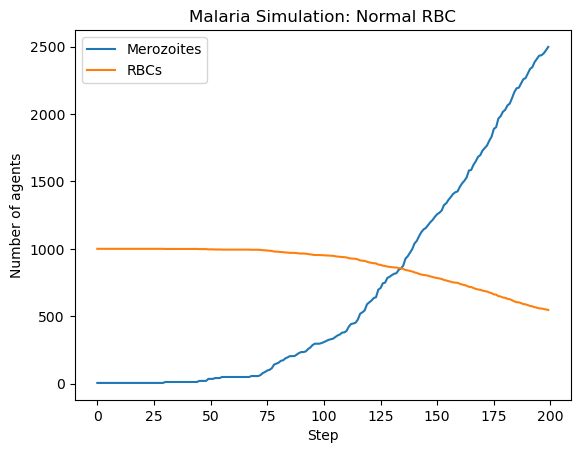

In [46]:
# simulation for healthy RBC with plot 

# Create a model instance
model1 = MalariaModel1(width=100, height=100, n_rbc=1000, n_mero=5, genotype="normal")

n_steps = 200  # number of time steps to simulate

# Run the simulation
for i in range(n_steps):
    model1.step()  # use the correct instance

# Convert collected data to pandas DataFrame
df1 = model1.datacollector.get_model_vars_dataframe()

# Plot results
df1.plot()
plt.xlabel("Step")
plt.ylabel("Number of agents")
plt.title("Malaria Simulation: Normal RBC")
plt.show()

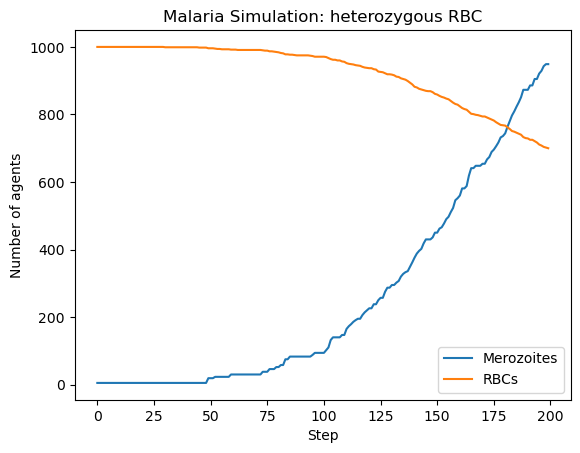

In [47]:
model2 = MalariaModel1(width=100, height=100, n_rbc=1000, n_mero=5, genotype="heterozygous")

n_steps = 200  # number of time steps to simulate

# Run the simulation
for i in range(n_steps):
    model2.step()  # use the correct instance

# Convert collected data to pandas DataFrame
df2 = model2.datacollector.get_model_vars_dataframe()

# Plot results
df2.plot()
plt.xlabel("Step")
plt.ylabel("Number of agents")
plt.title("Malaria Simulation: heterozygous RBC")
plt.show()

In [48]:
print(df1)

     Merozoites  RBCs
0             5  1000
1             5  1000
2             5  1000
3             5  1000
4             5  1000
..          ...   ...
195        2433   558
196        2436   557
197        2450   554
198        2473   550
199        2498   546

[200 rows x 2 columns]


In [49]:
print(df2)

     Merozoites  RBCs
0             5  1000
1             5  1000
2             5  1000
3             5  1000
4             5  1000
..          ...   ...
195         921   711
196         929   708
197         943   704
198         949   702
199         949   700

[200 rows x 2 columns]


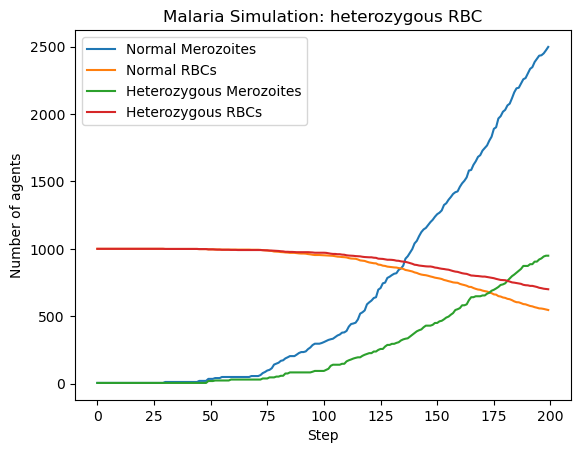

In [51]:
plt.plot(df1['Merozoites'], label='Normal Merozoites')
plt.plot(df1['RBCs'], label='Normal RBCs')
plt.plot(df2['Merozoites'], label='Heterozygous Merozoites')
plt.plot(df2['RBCs'], label='Heterozygous RBCs')
plt.xlabel("Step")
plt.ylabel("Number of agents")
plt.title("Malaria Simulation: heterozygous RBC")
plt.legend()
plt.show()